# Ecoregions

These polygons define the analysis extents over which we summarise NDVI seasonal cycles.

Original vector file from here: https://ecoregions.appspot.com/

Ecoregions is natural ecologies only, so we modify it by including cropping classes. The rainfed and irrigated cropping extents are taken from GFSAD ("lgrip30v001"), then we split these regions by biolcimatic region (rainfed) and by states (irrigated).  Also, some of the larger natural ecology polygons that cover a wide geogrpahic area are split further e.g. Eastern Australian temperature forests are split by bioclimatic regions.  Lastly, urban regions are removed.

In [1]:
%matplotlib inline
import os
import sys
import warnings
import rioxarray as rxr
import pandas as pd
import geopandas as gpd
import seaborn as sb
import xarray as xr
import numpy as np
from matplotlib.patches import Patch

import contextily as ctx
import matplotlib.pyplot as plt
import distinctipy
from matplotlib.colors import LinearSegmentedColormap

from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_vectorize

## Open data

In [2]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/Ecoregions2017_aus.geojson')
bioclim = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/bioclimatic_regions.geojson')

## Remove indonesian regions caught up in Aus extent clip

In [3]:
#remove tiny polys in Indo.
gdf = gdf[~gdf['ECO_NAME'].isin(["Trobriand Islands rain forests",
                                 "Sumba deciduous forests",
                                 "Timor and Wetar deciduous forests",
                                 "Louisiade Archipelago rain forests",
                                 "New Guinea mangroves",
                                "Southeast Papuan rain forests",
                                "Timor and Wetar deciduous forests"])].reset_index(drop=True)

## Divide eastern temperate forests into warm and cool temperate

In [4]:
# find the intersection of eastern temp forests and the climates
warm_temperate = bioclim[bioclim['region_name'] == 'Warm Temperate'].drop(['region_name','bioclimatic_regions'],axis=1)
cool_temperate = bioclim[bioclim['region_name'] == 'Cool Temperate'].drop(['region_name','bioclimatic_regions'],axis=1)
eatf = gdf[gdf['ECO_NAME']=='Eastern Australian temperate forests']
warm_eatf = gpd.overlay(warm_temperate, eatf, how='intersection')
cool_eatf = gpd.overlay(cool_temperate, eatf, how='intersection')

#update attrs
warm_eatf['ECO_NAME'] = 'Eastern Australian warm temperate forests'
cool_eatf['ECO_NAME'] = 'Eastern Australian cool temperate forests'

#plot
# fig,ax=plt.subplots(1,1)
# cool_eatf.plot(ax=ax, color='red')
# warm_eatf.plot(ax=ax, color='green');

In [5]:
#remove Eastern Australian temperate forests
gdf = gpd.overlay(gdf, eatf, how='symmetric_difference')

#tidy up
gdf = gdf.dropna(axis=1, how='all').rename({'ECO_NAME_1':'ECO_NAME',
                'BIOME_NAME_1':'BIOME_NAME', 'BIOME_NUM_1': 'BIOME_NUM'},axis=1)

#now add back the two EATF warm and EATF cool regions
gdf = pd.concat([gdf, warm_eatf, cool_eatf]) #join
gdf = gdf.drop(['BIOME_NAME', 'BIOME_NUM'],axis=1).reset_index(drop=True) #tidy


## Add cropping layers

Based on the GFSAD rainfed and irrigated cropping layers, derived from Landsat. See the `Cropland_GFSAD.ipynb` notebook.

Also dividing cropping regions into the state territories

* 0=nodata
* 1=noncrop
* 2-irrigated
* 3-rainfed

In [6]:
#create a cropping geometery
path = '/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc'
crop = assign_crs(xr.open_dataset(path), crs='epsg:4326')['croplands']

#individual classes
irrigated = (crop==2)
rainfed = (crop==3)

#vectorise
irrigated = xr_vectorize(irrigated, dtype='int16')
irrigated = irrigated[irrigated['attribute']==1.0]
irrigated['zone'] = 1
irrigated = irrigated.dissolve(by='zone', aggfunc='sum')
irrigated = irrigated.drop('attribute', axis=1)
irrigated['ECO_NAME'] = 'irrigated crop'

rainfed = xr_vectorize(rainfed, dtype='int16')
rainfed = rainfed[rainfed['attribute']==1.0]
rainfed['zone'] = 1
rainfed = rainfed.dissolve(by='zone', aggfunc='sum')
rainfed = rainfed.drop('attribute', axis=1)
rainfed['ECO_NAME'] = 'rainfed crop'

### Intersect cropping regions with ecoregions 

In [7]:
rainfed_crop_ecoregions = gdf.overlay(rainfed, how='union')
rainfed_crop_ecoregions['ECO_NAME'] = rainfed_crop_ecoregions['ECO_NAME_1'] +" "+ rainfed_crop_ecoregions['ECO_NAME_2']
rainfed_crop_ecoregions = rainfed_crop_ecoregions[~rainfed_crop_ecoregions['ECO_NAME'].isna()]
rainfed_crop_ecoregions = rainfed_crop_ecoregions[['ECO_NAME', 'geometry']]

irrigated_crop_ecoregions = gdf.overlay(irrigated, how='union')
irrigated_crop_ecoregions['ECO_NAME'] = irrigated_crop_ecoregions['ECO_NAME_1'] +" "+ irrigated_crop_ecoregions['ECO_NAME_2']
irrigated_crop_ecoregions = irrigated_crop_ecoregions[~irrigated_crop_ecoregions['ECO_NAME'].isna()]
irrigated_crop_ecoregions = irrigated_crop_ecoregions[['ECO_NAME', 'geometry']]

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/geopandas/geodataframe.py:2467: UserWarning: `keep_geom_type=True` in overlay resulted in 264 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


In [8]:
gdf = gpd.overlay(gdf, rainfed_crop_ecoregions, how='symmetric_difference')
gdf['ECO_NAME'] = gdf['ECO_NAME_1'].astype(str) + gdf['ECO_NAME_2'].astype(str)
gdf['ECO_NAME'] = gdf['ECO_NAME'].str.strip('nan')
gdf = gdf.drop(['ECO_NAME_1','ECO_NAME_2'], axis=1)

gdf = gpd.overlay(gdf, irrigated_crop_ecoregions, how='symmetric_difference')
gdf['ECO_NAME'] = gdf['ECO_NAME_1'].astype(str) + gdf['ECO_NAME_2'].astype(str)
gdf['ECO_NAME'] = gdf['ECO_NAME'].str.strip('nan')
gdf = gdf.drop(['ECO_NAME_1','ECO_NAME_2'], axis=1)

#now merge back together
gdf = pd.concat([gdf,rainfed_crop_ecoregions,irrigated_crop_ecoregions])
gdf = gdf.reset_index(drop=True) #tidy

In [9]:
# gdf.plot(column='ECO_NAME', figsize=(10,10))

## Remove urban regions

In [10]:
urban = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/urban_mask_1km.nc')
urban = xr_vectorize(urban, dtype='int16')
urban = urban[urban['attribute']==1.0]
urban['zone'] = 1
urban = urban.dissolve(by='zone', aggfunc='sum')
urban = urban.drop('attribute', axis=1)
gdf = gpd.overlay(gdf, urban, how='symmetric_difference')
gdf = gdf.dropna(axis=0, how='any').reset_index(drop=True)

## Filter very small polygons

In [11]:
gdf = gdf.to_crs('EPSG:3577')
gdf["area_ha"] = gdf.geometry.area /10000
gdf = gdf[gdf["area_ha"]>2500]
gdf = gdf.to_crs('EPSG:4326')
gdf = gdf.drop('area_ha', axis=1)

In [12]:
print(len(gdf))

80


## Plot

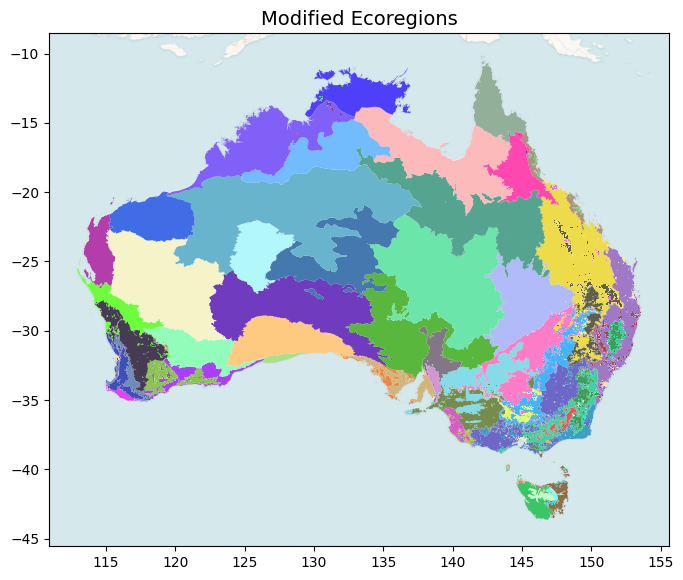

In [13]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

colors = distinctipy.get_colors(len(gdf), pastel_factor=0.3)
a = gdf.plot(column='ECO_NAME', ax=ax, legend=False, cmap=LinearSegmentedColormap.from_list(
        'ecoregions', colors, N=len(gdf)))
ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
plt.title('Modified Ecoregions', fontsize=14);
fig.savefig('/g/data/os22/chad_tmp/Aus_phenology/results/figs/ecoregions.png', bbox_inches='tight', dpi=300)

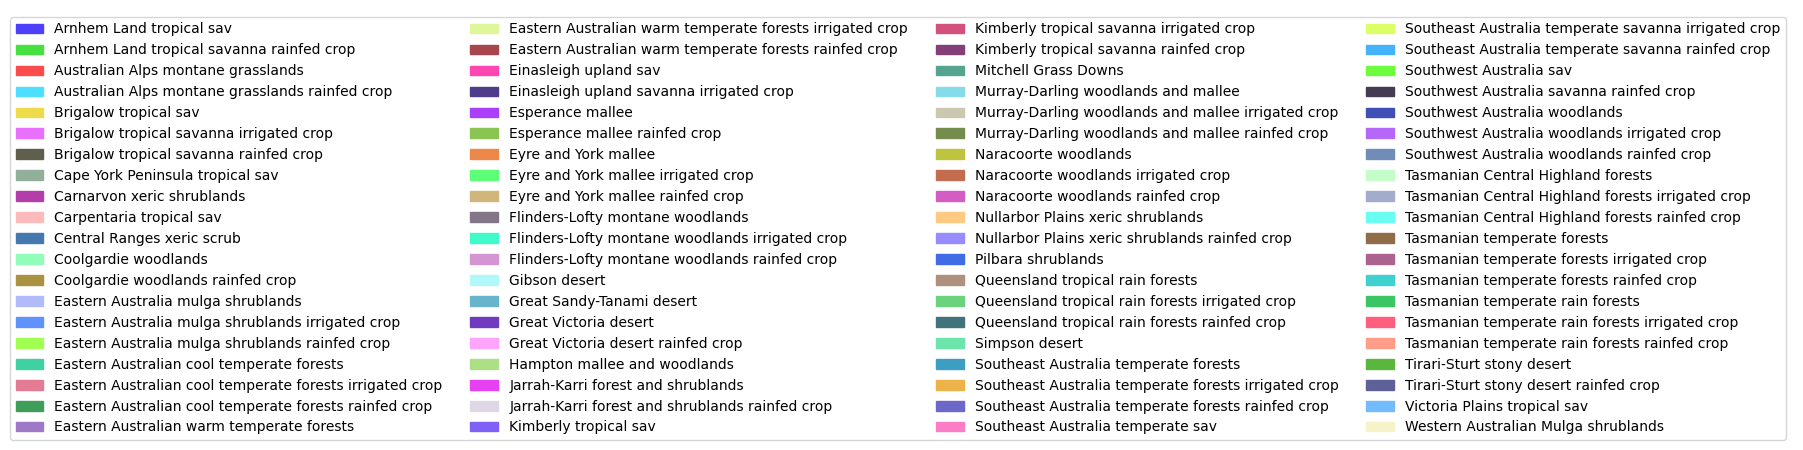

In [14]:
names=list(gdf['ECO_NAME'])
names.sort()
legend_elements = [Patch(facecolor=c, edgecolor=c,label=n) for c,n in zip(colors,names)]
# Create the figure
fig, ax = plt.subplots()
ax.axis(False)
ax.legend(handles=legend_elements, loc="best", fontsize=10, ncol=4);
fig.savefig('/g/data/os22/chad_tmp/Aus_phenology/results/figs/ecoregions_legend.png', bbox_inches='tight', dpi=300)

## Save file

In [15]:
gdf.to_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/Ecoregions2017_modified.geojson')

## Interactive plot

In [16]:
# gdf.explore(column='ECO_NAME',
#            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#            attr = 'Esri',
#            name = 'Esri Satellite',
#            )

### Split crops by bioclim region

Additionally split the mediterranean region by east/west

In [17]:
# states = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/state_boundaries.geojson')
# states = states.drop(['STE_CODE21', 'CHG_FLAG21', 'CHG_LBL21', 'AUS_CODE21',
#        'AUS_NAME21', 'AREASQKM21', 'LOCI_URI21'], axis=1)

# wa = states[states['STE_NAME21'] == 'Western Australia']
# wa = wa.drop(['STE_NAME21'], axis=1)

# sa_vic_nsw = states[states['STE_NAME21'].isin(['South Australia', 'Victoria', 'New South Wales'])]
# sa_vic_nsw = sa_vic_nsw.drop('STE_NAME21', axis=1)
# sa_vic_nsw['zone'] = 1
# sa_vic_nsw = sa_vic_nsw.dissolve(by='zone', aggfunc='sum')

# nsw = states[states['STE_NAME21'] == 'New South Wales']
# nsw = nsw.drop(['STE_NAME21'], axis=1)

# sa = states[states['STE_NAME21'] == 'South Australia']
# sa = sa.drop(['STE_NAME21'], axis=1)

# vic = states[states['STE_NAME21'] == 'Victoria']
# vic = vic.drop(['STE_NAME21'], axis=1)

# qld = states[states['STE_NAME21'] == 'Queensland']
# qld = qld.drop(['STE_NAME21'], axis=1)

# tas = states[states['STE_NAME21'] == 'Tasmania']
# tas = tas.drop(['STE_NAME21'], axis=1)


In [18]:
# # isolate biolcim regions
# med = bioclim[bioclim['region_name'] == 'Mediterranean'].drop(['region_name','bioclimatic_regions'],axis=1)
# cool_temperate = bioclim[bioclim['region_name'] == 'Cool Temperate'].drop(['region_name','bioclimatic_regions'],axis=1)
# warm_temperate = bioclim[bioclim['region_name'] == 'Warm Temperate'].drop(['region_name','bioclimatic_regions'],axis=1)
# savanna = bioclim[bioclim['region_name'] == 'Savanna'].drop(['region_name','bioclimatic_regions'],axis=1)
# tropics = bioclim[bioclim['region_name'] == 'Tropics'].drop(['region_name','bioclimatic_regions'],axis=1)

# # find the intersection of rainfed crops and the climates (split mediterranean into WA, east)
# # (also split cool temp into Tassie and mainland)
# warm_temp_crop = gpd.overlay(warm_temperate, rainfed, how='intersection')
# cool_temp_crop = gpd.overlay(cool_temperate, rainfed, how='intersection')
# cool_temp_crop_tas = gpd.overlay(cool_temp_crop, tas, how='intersection')
# cool_temp_crop_se = gpd.overlay(cool_temp_crop, sa_vic_nsw, how='intersection')
# savanna_crop = gpd.overlay(savanna, rainfed, how='intersection')
# # tropics_crop = gpd.overlay(tropics, rainfed, how='intersection')
# med_crop = gpd.overlay(med, rainfed, how='intersection')
# med_crop_wa = gpd.overlay(med_crop, wa, how='intersection')
# med_crop_east = gpd.overlay(med_crop, sa_vic_nsw, how='intersection')

# # find the intersection of irrigated crops and the states
# wa_irrigated = gpd.overlay(wa, irrigated, how='intersection')
# sa_irrigated = gpd.overlay(sa, irrigated, how='intersection')
# vic_irrigated = gpd.overlay(vic, irrigated, how='intersection')
# nsw_irrigated = gpd.overlay(nsw, irrigated, how='intersection')
# qld_irrigated = gpd.overlay(qld, irrigated, how='intersection')
# # nt_irrigated = gpd.overlay(nt, irrigated, how='intersection')

# #remove areas in ecoregions where rainfed and irrigated crops are
# gdf = gpd.overlay(gdf, warm_temp_crop, how='symmetric_difference')
# gdf = gpd.overlay(gdf, cool_temp_crop_tas, how='symmetric_difference')
# gdf = gpd.overlay(gdf, cool_temp_crop_se, how='symmetric_difference')
# gdf = gpd.overlay(gdf, savanna_crop, how='symmetric_difference')
# gdf = gpd.overlay(gdf, med_crop_wa, how='symmetric_difference')
# gdf = gpd.overlay(gdf, med_crop_east, how='symmetric_difference')
# gdf = gpd.overlay(gdf, wa_irrigated, how='symmetric_difference')
# gdf = gpd.overlay(gdf, sa_irrigated, how='symmetric_difference')
# gdf = gpd.overlay(gdf, vic_irrigated, how='symmetric_difference')
# gdf = gpd.overlay(gdf, nsw_irrigated, how='symmetric_difference')
# gdf = gpd.overlay(gdf, qld_irrigated, how='symmetric_difference')
# # gdf = gpd.overlay(gdf, tropics_crop, how='symmetric_difference')
# # gdf = gpd.overlay(gdf, nt_irrigated, how='symmetric_difference')

# #add attrs
# warm_temp_crop['ECO_NAME'] = 'Rainfed cropping warm temperate'
# cool_temp_crop_tas['ECO_NAME'] = 'Rainfed cropping cool temperate TAS'
# cool_temp_crop_se['ECO_NAME'] = 'Rainfed cropping cool temperate mainland'
# savanna_crop['ECO_NAME'] = 'Rainfed cropping savanna'
# # tropics_crop['ECO_NAME'] = 'Rainfed cropping tropics'
# med_crop_wa['ECO_NAME'] = 'Rainfed cropping mediterranean West'
# med_crop_east['ECO_NAME'] = 'Rainfed cropping mediterranean East'
# wa_irrigated['ECO_NAME'] = 'Irrigated cropping WA'
# sa_irrigated['ECO_NAME'] = 'Irrigated cropping SA'
# vic_irrigated['ECO_NAME'] = 'Irrigated cropping VIC'
# nsw_irrigated['ECO_NAME'] = 'Irrigated cropping NSW'
# qld_irrigated['ECO_NAME'] = 'Irrigated cropping QLD'
# # nt_irrigated['ECO_NAME'] = 'Irrigated cropping NT'

In [19]:
# gdf = pd.concat([gdf, warm_temp_crop, cool_temp_crop_se, cool_temp_crop_tas, savanna_crop, med_crop_wa,
#                 med_crop_east, wa_irrigated, sa_irrigated, vic_irrigated, nsw_irrigated,
#                 qld_irrigated,#nt_irrigated tropics_crop,
#                 ])

In [20]:
# gdf = gdf.drop(['BIOME_NAME', 'BIOME_NUM'],axis=1).dropna(axis=0, how='any').reset_index(drop=True) #tidy

In [21]:
# gdf.explore(column='ECO_NAME')